<a href="https://colab.research.google.com/github/DrakeData/House_Price_EDA/blob/sandbox/MSDS422_Assignmetn3_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 - House Prices: Advanced Regression Techniques (Continued)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn import preprocessing
from numpy import array
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline
sns.set()

## Ingest
Here I will be ingesting the data that I cleaned up in assignment 1. The code for this cleanup process can be in [MSDS422_Assignment1.ipynb](https://github.com/DrakeData/House_Price_EDA/blob/main/MSDS422_Assignment1.ipynb).

### Import Data
'train_clean.csv' and 'test_clean.csv' is the cleaned up trained data set that worked on in Assignment 1.

In [2]:
df_train = pd.read_csv('./drive/MyDrive/Colab Notebooks/House_Price_EDA/data/train_clean.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSqft,TotalBath,HouseAge,ReModeled
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,2566,3.5,5,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,0,1262,0,1,2,0,3,1,TA,6,Typ,1,3,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,2524,2.5,31,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,3,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,2706,3.5,7,1
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,4,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,2473,2.0,91,1
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,3,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,3343,3.5,8,0


In [3]:
df_test = pd.read_csv('./drive/MyDrive/Colab Notebooks/House_Price_EDA/data/test_clean.csv')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSqft,TotalBath,HouseAge,ReModeled
0,1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,0,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,None,MnPrv,None,0,6,2010,WD,Normal,1778.0,1.0,49,0
1,1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,0,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,None,None,Gar2,12500,6,2010,WD,Normal,2658.0,1.5,52,0
2,1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,3,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,None,MnPrv,None,0,3,2010,WD,Normal,2557.0,2.5,13,1
3,1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,4,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,None,None,None,0,6,2010,WD,Normal,2530.0,2.5,12,0
4,1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,0,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,None,None,None,0,1,2010,WD,Normal,2560.0,2.0,18,0


## EDA
Before we pass the data through a model, we should explore the data and see if there is any additional work that needs to be done to it.

#### Train Set Check

In [12]:
df_train.shape

(1458, 86)

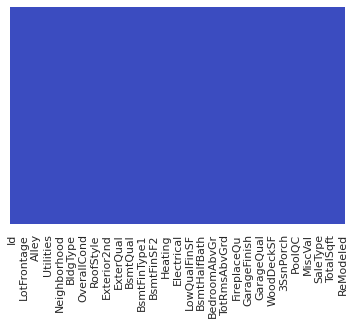

In [4]:
# Heatmap check for nulls in train set
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False, cmap='coolwarm');

In [5]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 85 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1458 non-null   int64  
 1   MSSubClass     1458 non-null   int64  
 2   MSZoning       1458 non-null   object 
 3   LotFrontage    1458 non-null   float64
 4   LotArea        1458 non-null   int64  
 5   Street         1458 non-null   object 
 6   Alley          1458 non-null   object 
 7   LotShape       1458 non-null   object 
 8   LandContour    1458 non-null   object 
 9   Utilities      1458 non-null   object 
 10  LotConfig      1458 non-null   object 
 11  LandSlope      1458 non-null   object 
 12  Neighborhood   1458 non-null   object 
 13  Condition1     1458 non-null   object 
 14  Condition2     1458 non-null   object 
 15  BldgType       1458 non-null   object 
 16  HouseStyle     1458 non-null   object 
 17  OverallQual    1458 non-null   int64  
 18  OverallC

In [6]:
# List of int64 values
int64_ls = ['Id', 'MSSubClass', 'LotFrontage', 'LotArea',
            'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
            'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
            'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
            'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
            'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
            'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
            'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
            'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold',
            'YrSold', 'SalePrice', 'TotalSqft', 'TotalBath', 
            'HouseAge', 'ReModeled']

# Update dtypes to int64 in train set
for col in int64_ls:
  df_train[col] = df_train[col].astype(int)

# Update dtypes to int64 in test set
for col in int64_ls:
  try:
    df_test[col] = df_test[col].astype(int)
  except KeyError:
    pass

# List of string values
string_ls = ['Street', 'Alley', 'LotShape', 'LandContour', 
             'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
             'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
             'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
             'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
             'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
             'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
             'SaleCondition']

# Update dtypes to strings in train set
for col in string_ls:
  df_train[col] = df_train[col].astype(pd.StringDtype())

# Update dtypes to strings in test set
for col in string_ls:
  df_test[col] = df_test[col].astype(pd.StringDtype())

In [7]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 85 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             1458 non-null   int64 
 1   MSSubClass     1458 non-null   int64 
 2   MSZoning       1458 non-null   object
 3   LotFrontage    1458 non-null   int64 
 4   LotArea        1458 non-null   int64 
 5   Street         1458 non-null   string
 6   Alley          1458 non-null   string
 7   LotShape       1458 non-null   string
 8   LandContour    1458 non-null   string
 9   Utilities      1458 non-null   string
 10  LotConfig      1458 non-null   string
 11  LandSlope      1458 non-null   string
 12  Neighborhood   1458 non-null   string
 13  Condition1     1458 non-null   string
 14  Condition2     1458 non-null   string
 15  BldgType       1458 non-null   string
 16  HouseStyle     1458 non-null   string
 17  OverallQual    1458 non-null   int64 
 18  OverallCond    1458 non-null

#### Test Set Check
It is good practice to check the test set to verify that it did not contain any additional null values in different columns compared to the train set.

In [14]:
df_test.shape

(1459, 85)

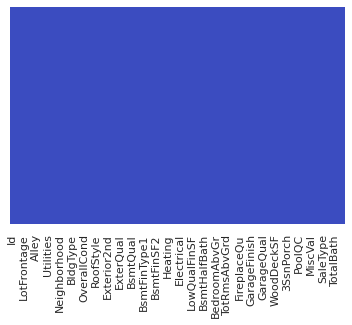

In [8]:
# Heatmap check for nulls in train set
sns.heatmap(df_test.isnull(), yticklabels=False, cbar=False, cmap='coolwarm');

In [9]:
df_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 84 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             1459 non-null   int64 
 1   MSSubClass     1459 non-null   int64 
 2   MSZoning       1459 non-null   object
 3   LotFrontage    1459 non-null   int64 
 4   LotArea        1459 non-null   int64 
 5   Street         1459 non-null   string
 6   Alley          1459 non-null   string
 7   LotShape       1459 non-null   string
 8   LandContour    1459 non-null   string
 9   Utilities      1459 non-null   string
 10  LotConfig      1459 non-null   string
 11  LandSlope      1459 non-null   string
 12  Neighborhood   1459 non-null   string
 13  Condition1     1459 non-null   string
 14  Condition2     1459 non-null   string
 15  BldgType       1459 non-null   string
 16  HouseStyle     1459 non-null   string
 17  OverallQual    1459 non-null   int64 
 18  OverallCond    1459 non-null

### Create New Variable
Adding a new feature:
* Total housing area (total_house_area): adds up the total area of the house (1stFlrSF + 2ndFlrSF + TotalBsmtSF)

In [10]:
# train set
df_train["total_house_area"] = df_train["1stFlrSF"] + df_train["2ndFlrSF"] + df_train["TotalBsmtSF"]

# test set
df_test["total_house_area"] = df_test["1stFlrSF"] + df_test["2ndFlrSF"] + df_test["TotalBsmtSF"]

### Check for skewness in the train data set

In [42]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

dataset_numeric = df_train.select_dtypes(include=numerics)
dataset_numeric.shape

(1458, 43)

In [33]:
dataset_numeric.skew()

Id                   0.000165
MSSubClass           1.407011
LotFrontage          1.507064
LotArea             -0.181278
OverallQual          0.200786
OverallCond          0.691035
YearBuilt           -0.612295
YearRemodAdd        -0.501838
MasVnrArea           2.696329
BsmtFinSF1           0.764789
BsmtFinSF2           4.251925
BsmtUnfSF            0.920903
TotalBsmtSF          0.511703
1stFlrSF             0.887637
2ndFlrSF             0.812957
LowQualFinSF         7.333148
GrLivArea            1.010992
BsmtFullBath         0.590358
BsmtHalfBath         4.100114
FullBath             0.031271
HalfBath             0.680051
BedroomAbvGr         0.212325
KitchenAbvGr         4.484883
TotRmsAbvGrd         0.660502
Fireplaces           0.632060
GarageYrBlt         -0.693237
GarageCars          -0.342377
GarageArea           0.131748
WoodDeckSF           1.545805
OpenPorchSF          2.339829
EnclosedPorch        3.087164
3SsnPorch            7.641307
ScreenPorch          4.118929
PoolArea  

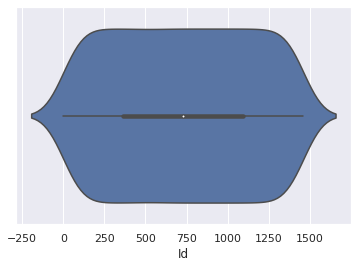

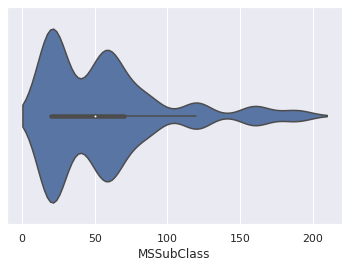

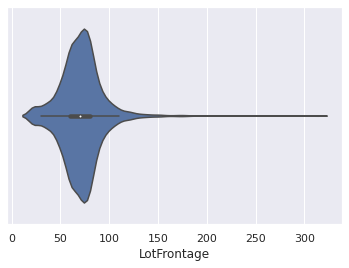

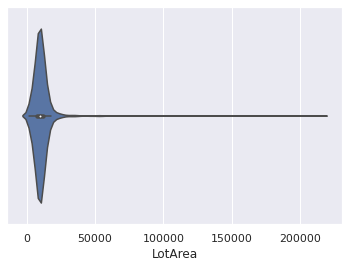

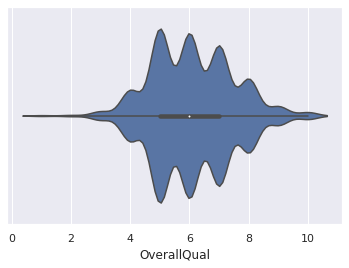

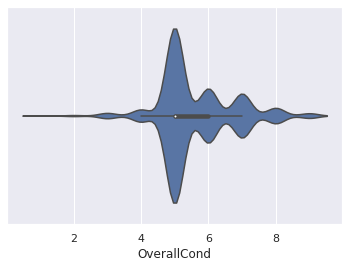

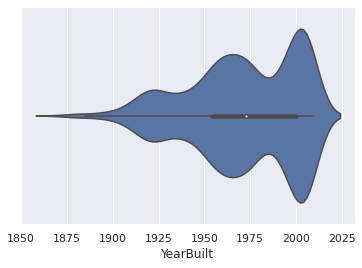

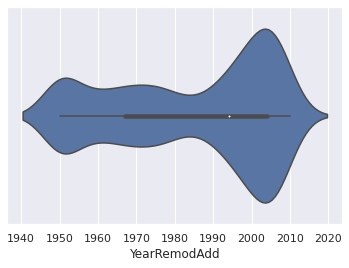

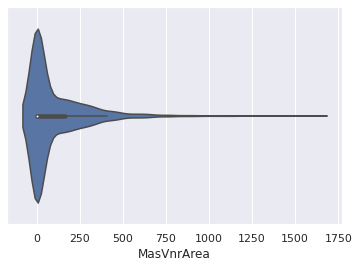

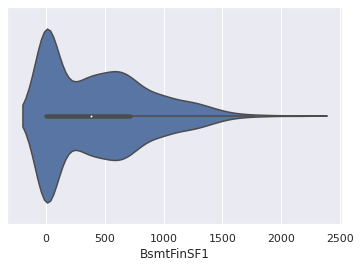

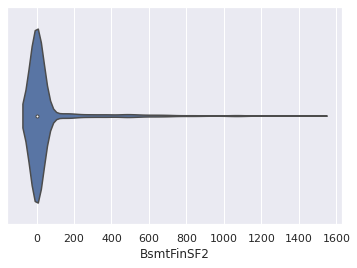

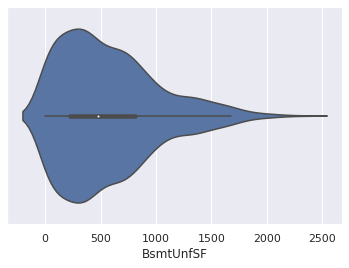

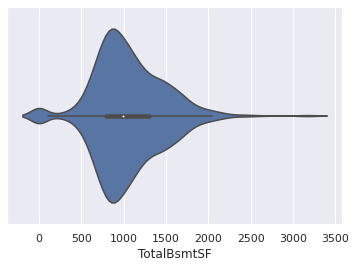

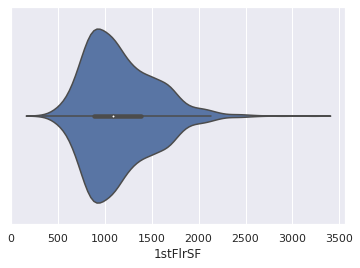

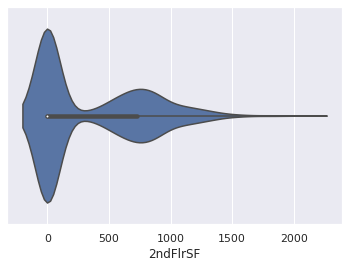

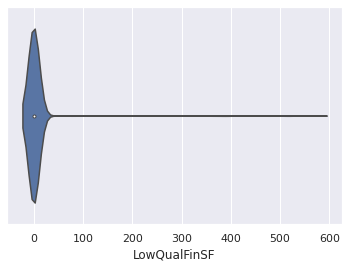

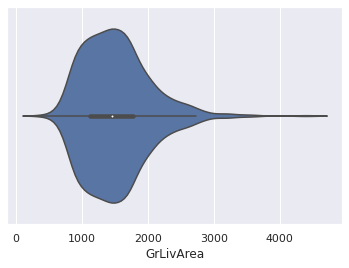

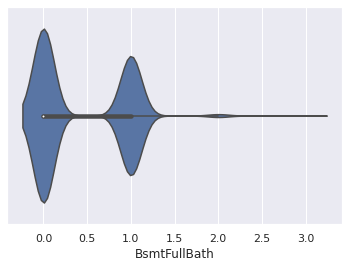

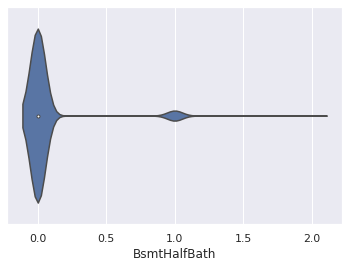

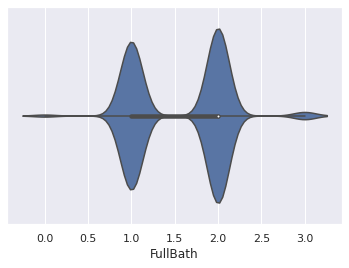

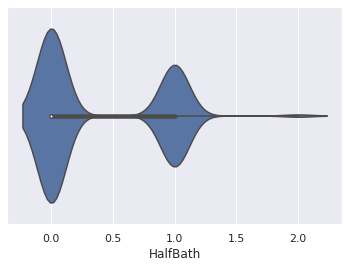

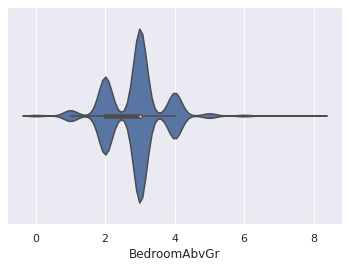

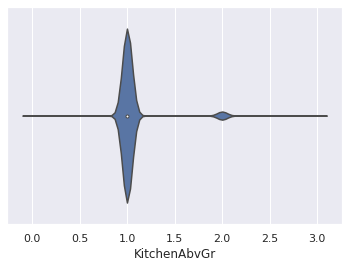

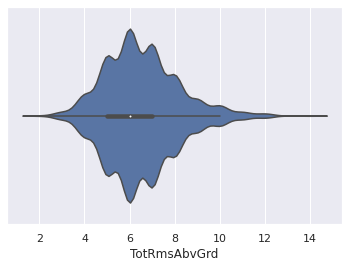

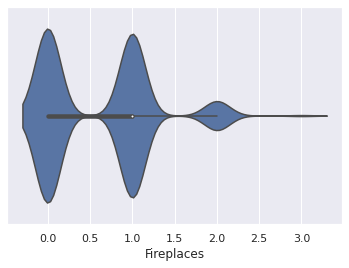

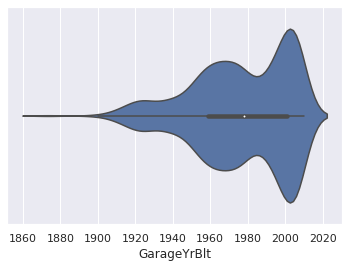

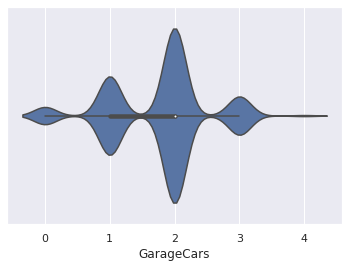

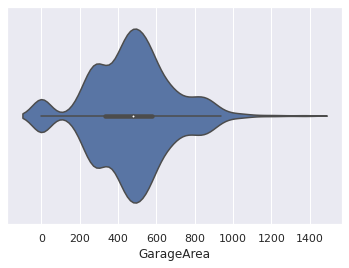

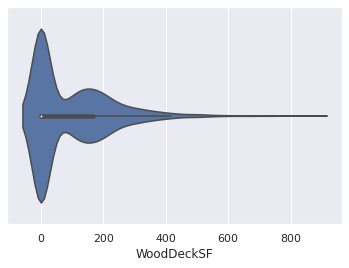

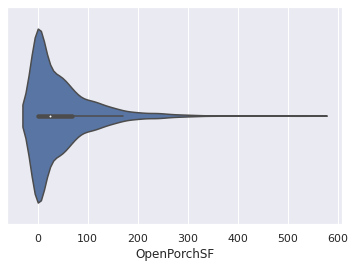

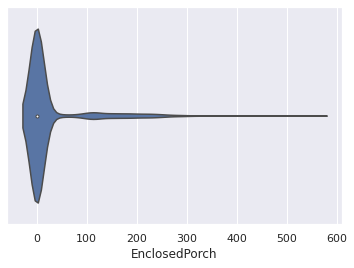

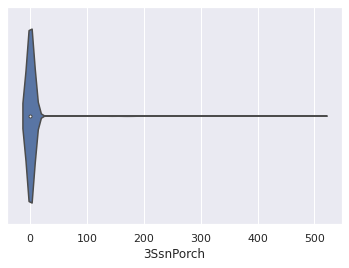

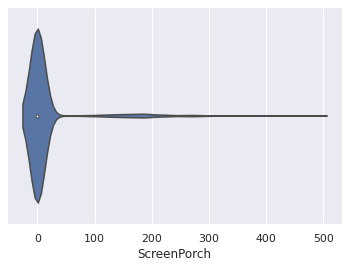

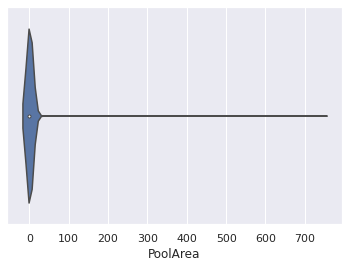

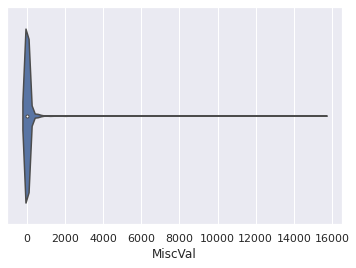

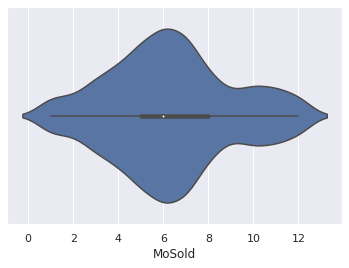

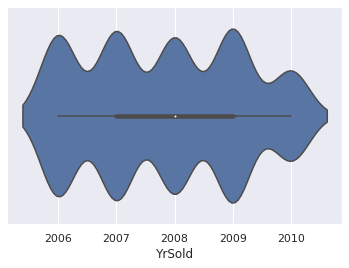

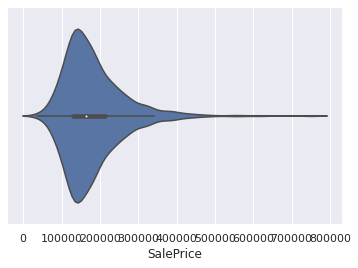

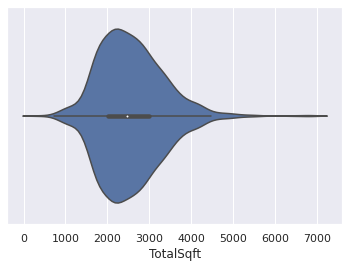

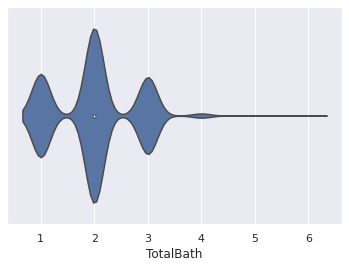

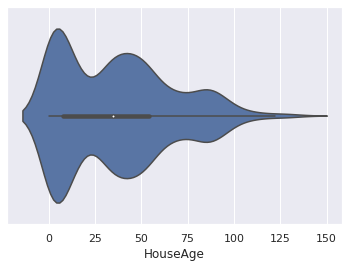

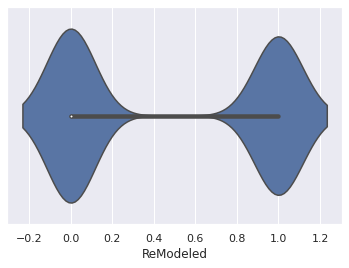

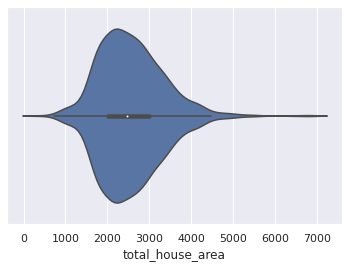

In [28]:
cols = dataset_numeric.columns

for c in cols:
  sns.violinplot(x=dataset_numeric[c])
  plt.xlabel(c)
  plt.show()

Looking at the above graphs, we can see that there are several data point that are negatively skewed to the left side of the distribution (ex: LotFrontage, LotArea, MasVnrArea, etc.). We would want to decrease the skew and make it closer to normal distribution.

In [40]:
# Skew Correction
#log1p function applies log(1+x) to all elements of the column
skew = df_train.select_dtypes(include=numerics).skew()

# disabling the pandas warning
pd.options.mode.chained_assignment = None

skewedfeatures = [s for s in skew if(s > 5.0)]
skewedfeatures

for skf in skewedfeatures:
  sk = skew[skew == skf].index[0]
  df_train[sk] = np.log1p(df_train[sk])

In [41]:
# Same thing for the test set
skew = df_test.select_dtypes(include=numerics).skew()

# disabling the pandas warning
pd.options.mode.chained_assignment = None

skewedfeatures = [s for s in skew if(s > 5.0)]
skewedfeatures

for skf in skewedfeatures:
  sk = skew[skew == skf].index[0]
  df_test[sk] = np.log1p(df_test[sk])

### Checking correlation betwenn numeric values

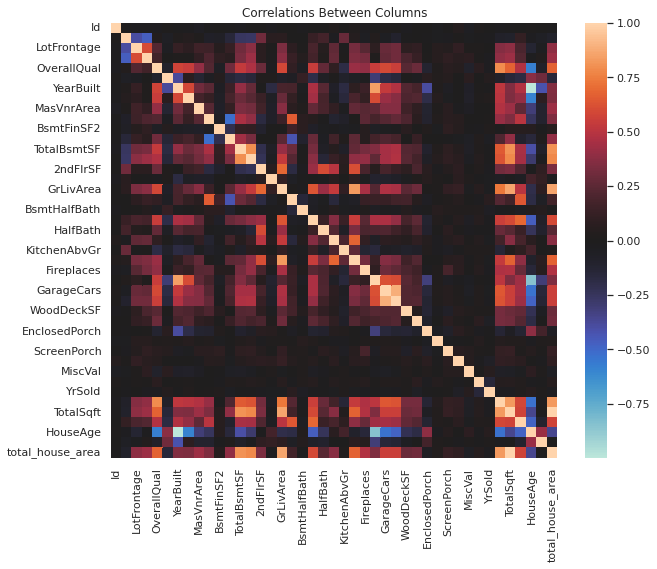

In [35]:
plt.figure(figsize=(10,8))
sns.heatmap(dataset_numeric.corr(), center = 0)
plt.title("Correlations Between Columns")
plt.show()

In [34]:
# Correlation tells relation between two attributes.
# Correlation requires continous data. Hence, ignore categorical data

# Calculates pearson co-efficient for all combinations
data_corr = dataset_numeric.corr()

# Set the threshold to select only highly correlated attributes
threshold = 0.5

# List of pairs along with correlation above threshold
corr_list = []

size = 36

#Search for the highly correlated pairs
for i in range(0,size): #for 'size' features
    for j in range(i+1,size): #avoid repetition
        if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1) or (data_corr.iloc[i,j] < 0 and data_corr.iloc[i,j] <= -threshold):
            corr_list.append([data_corr.iloc[i,j],i,j]) #store correlation and columns index

#Sort to show higher ones first            
s_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

#Print correlations and column names
for v,i,j in s_corr_list:
    print ("%s and %s = %.2f" % (cols[i],cols[j],v))

GarageCars and GarageArea = 0.89
YearBuilt and GarageYrBlt = 0.84
GrLivArea and TotRmsAbvGrd = 0.83
TotalBsmtSF and 1stFlrSF = 0.80
2ndFlrSF and GrLivArea = 0.69
BedroomAbvGr and TotRmsAbvGrd = 0.68
BsmtFinSF1 and BsmtFullBath = 0.66
GrLivArea and FullBath = 0.64
GarageYrBlt and GarageCars = 0.62
2ndFlrSF and TotRmsAbvGrd = 0.61
2ndFlrSF and HalfBath = 0.61
YearRemodAdd and GarageYrBlt = 0.60
GarageYrBlt and GarageArea = 0.60
LotFrontage and LotArea = 0.60
OverallQual and GarageCars = 0.60
YearBuilt and YearRemodAdd = 0.59
OverallQual and GrLivArea = 0.59
OverallQual and YearBuilt = 0.57
OverallQual and GarageArea = 0.56
OverallQual and GarageYrBlt = 0.55
FullBath and TotRmsAbvGrd = 0.55
OverallQual and YearRemodAdd = 0.55
OverallQual and FullBath = 0.55
OverallQual and TotalBsmtSF = 0.54
GrLivArea and BedroomAbvGr = 0.54
YearBuilt and GarageCars = 0.54
1stFlrSF and GrLivArea = 0.53
BsmtFinSF1 and BsmtUnfSF = -0.52
2ndFlrSF and BedroomAbvGr = 0.50


From the above data, we can see that GarageCars and GarageArea are highly correlated. To limit the noise in our data set, we will make sure not to include GarageCars in our models.

## Modeling